# This file will evaluate the results from `bilby_pipe` in bulk

## Imports

In [12]:
import numpy as np
import pandas as pd
import bilby
import os
import bilby.gw.result as bilby_result
import ast
import matplotlib.pyplot as plt
import ligo.skymap.plot.pp as ppplot

plt.rcParams.update({

    # --- Figure Layout ---
    "figure.figsize": (6, 4),           # Default figure size in inches
    "figure.dpi": 150,                  # DPI for crisp rendering
    "savefig.dpi": 300,                 # Higher DPI for saved figures
    "figure.autolayout": True,          # Avoids label overlap

    # --- Font & Text ---
    "font.family": "monospace",             # Or "sans-serif" for modern look
    "font.serif": ["Terminal"],  # Matches many journals
    "font.size": 10,                    # Base font size
    "axes.titlesize": 14,               # Title font size
    "axes.labelsize": 10,               # Axis label size
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "mathtext.fontset": "dejavuserif",  # Matches the serif font

    # --- Line & Marker Styles ---
    "lines.linewidth": 1.8,
    "lines.markersize": 6,
    "lines.markeredgewidth": 0.7,

    # --- Axes ---
    "axes.linewidth": 1.0,              # Frame thickness
    "axes.labelpad": 6,                 # Padding between label and axis
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.7,
    "axes.spines.top": False,           # Removes top spine
    "axes.spines.right": False,         # Removes right spine

    # --- Ticks ---
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "xtick.top": False,
    "ytick.right": False,

    # --- Legend ---
    "legend.frameon": False,
    "legend.handlelength": 2,
    "legend.handletextpad": 0.4,
    "legend.loc": "best",

    # --- Colors and Colormaps ---
    "image.cmap": "viridis",            # Good perceptually uniform default
    "axes.prop_cycle": plt.cycler("color", [
        "#1f77b4", "#ff7f0e", "#2ca02c",
        "#d62728", "#9467bd", "#8c564b",
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]),
})

## Function definitions

In [13]:
def getMeaningfulColumns(differenceDF):
    cols=[]
    for col in differenceDF:
        if differenceDF[col].isna().all():
            continue
        else:
            cols.append(col)
    return cols

def makePostInjDiffPlot(columns,differenceDF,event=False):
    nrows = int(np.ceil((len(columns))/5))
    fig,axs = plt.subplots(nrows,5,figsize=[10,2*nrows])
    if type(event)==str:
        fig.suptitle(f"{event} - Injection value for ensemble")
    else:
        fig.suptitle(f"Posterior samples - Injection for different parameters of event\n{event.label}")
    for col,ax in zip(columns,axs.flatten()):
        ax.hist(differenceDF[col],histtype='step')
        # ax.grid()
        ax.set_xlabel(col)
        ax.axvline(0,0,ax.get_ylim()[1],color='red')
        # if not (type(event)==str):
        #     ax.set_title(f"True: {}")
    for ax in axs[:,0]:
        ax.set_ylabel("Counts / bin")
    fig.tight_layout(pad=2)
    return fig,axs

def getResult(path,injectionDir="injectionFiles",injectionSuffix="_injection.dat",verbose=False):
    """
    A function to read a path where the bilby_pipe run
    is stored, and return a complete CBCResult object
    """
    parentPath = "/".join(path.split("/")[:-1])
    label = path.split("/")[-1] # The label, taking the form UniformParent,uWeight_aligned_BBH_5
    # Return the final result
    readPath = os.path.join(parentPath,label,"final_result",label+"_data0_0_analysis_H1L1V1_result.hdf5")
    if verbose:
        print(f"ReadPath: {readPath}")
    return bilby_result.CBCResult.from_hdf5(readPath)

def getEventsFromPath(path):
    """
    A function to read all CBC events from a parent catalog directory
    """
    print(f"Reading events from {path}")
    allEvents = []
    eventDirectories = os.listdir(path)
    for event in list(eventDirectories):
        try:
            allEvents.append(getResult(os.path.join(path,event)))
        except:
            print(f"Could not open {event}")
            continue
    return allEvents

In [14]:
testingPath = "/pscratch/sd/s/seanmacb/proj411ProdRuns/testing/"

In [15]:
msk = [(x.lower().startswith("testing")) and (not x.__contains__("testing_2")) for x in os.listdir(testingPath)]
testing_directories = np.sort(np.array(os.listdir(testingPath))[np.array(msk)])

In [16]:
testing_directories

array(['testing_0', 'testing_1', 'testing_3', 'testing_4'], dtype='<U20')

09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Reading from directory testing_3
Reading events from /pscratch/sd/s/seanmacb/proj411ProdRuns/testing/testing_3


09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Could not open allInis.txt


09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:10 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open UniformParent,uWeight_aligned_BBH_5


09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:10 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:10 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open testRun.sh


09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:11 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open iniFiles


09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:11 bilby INFO    : Global meta data was removed from the result object for compatibility

Could not open injectionFiles


09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data
09:11 bilby INFO    : Global meta data was removed from the result object for compatibility. Use the `BILBY_INCLUDE_GLOBAL_METADATA` environment variable to include it. This behaviour will be removed in a future release. For more details see: https://bilby-dev.github.io/bilby/faq.html#global-meta-data


Number of events for testing_3: 49


09:11 bilby INFO    : Key: KS-test p-value
09:11 bilby INFO    : mass_ratio: 0.017953387407587118
09:11 bilby INFO    : chirp_mass: 0.8675934639898233
09:11 bilby INFO    : luminosity_distance: 0.8459852864478437
09:11 bilby INFO    : dec: 0.9497864819040553
09:11 bilby INFO    : ra: 0.37896939410090147
09:11 bilby INFO    : chi_1: nan
09:11 bilby INFO    : chi_2: nan
09:11 bilby INFO    : psi: 0.8554867092316484
09:11 bilby INFO    : phase: 0.6956742726851357
09:11 bilby INFO    : theta_jn: 0.5651859071068591
09:11 bilby INFO    : geocent_time: 0.2596923972240942
09:11 bilby INFO    : Combined p-value: nan
09:11 bilby INFO    : Key: KS-test p-value
09:11 bilby INFO    : luminosity_distance: 0.8459852864478437
09:11 bilby INFO    : chirp_mass: 0.8675934639898233
09:11 bilby INFO    : ra: 0.37896939410090147
09:11 bilby INFO    : dec: 0.9497864819040553
09:11 bilby INFO    : mass_ratio: 0.017953387407587118
09:11 bilby INFO    : Combined p-value: 0.3811884012689658


CPU times: user 6.91 s, sys: 317 ms, total: 7.23 s
Wall time: 7.25 s


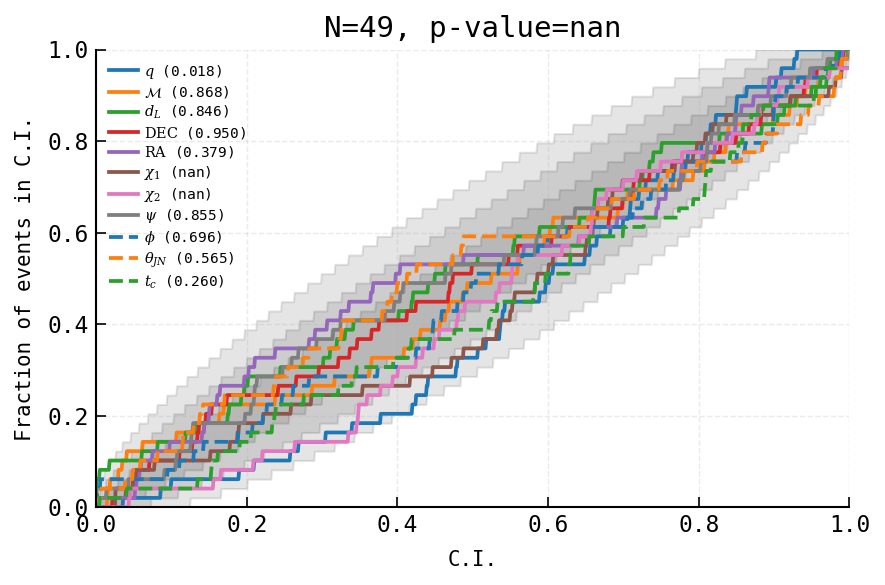

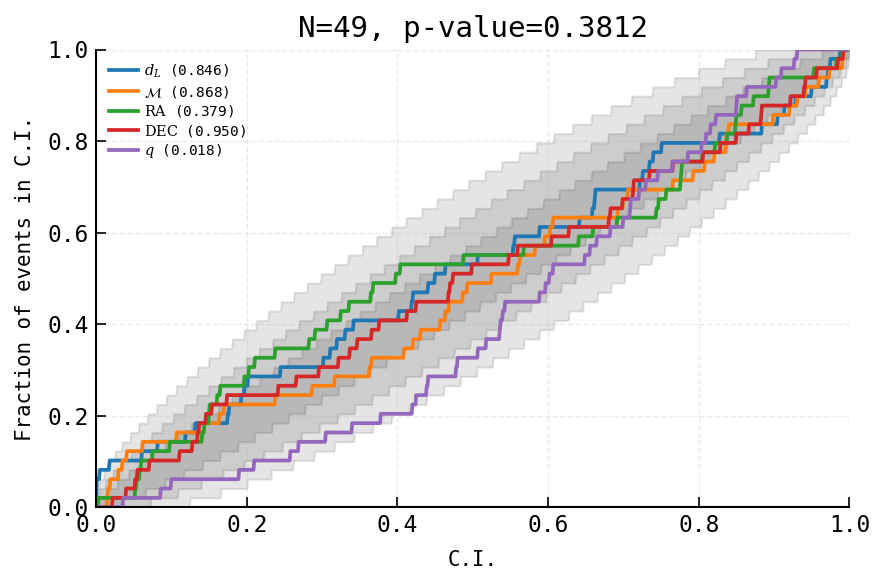

In [18]:
%%time 
for t in [testing_directories[2]]:
    t_directory = os.path.join(testingPath,t)
    print(f"Reading from directory {t}")
    allEvents = getEventsFromPath(t_directory)
    print(f"Number of events for {t}: {len(allEvents)}")
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}.png",)
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}_inset.png",keys=["luminosity_distance","chirp_mass","ra","dec","mass_ratio"])

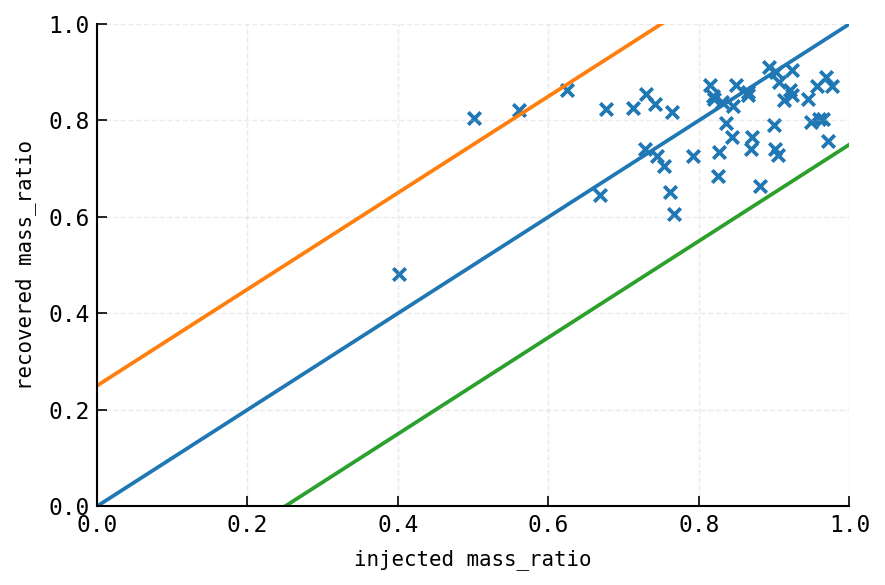

KeyError: 'chi_1'

In [35]:
questionable_params = ["mass_ratio","chi_1"]

for p in questionable_params:
    inj,rec = [],[]
    for ev in allEvents:
        inj.append(ev.injection_parameters[p])
        rec.append(np.median(ev.posterior[p]))
    plt.scatter(inj,rec,marker='x')
    plt.plot([0,1],[0,1])
    plt.plot([0,1],[0.25,1.25])
    plt.plot([0,1],[-0.25,0.75])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel(f"injected {p}")
    plt.ylabel(f"recovered {p}")
    plt.show()

In [28]:
# allEvents[0].posterior["chi_1"]
ev.injection_parameters.keys()

dict_keys(['H1_log_likelihood', 'H1_matched_filter_snr', 'H1_optimal_snr', 'L1_log_likelihood', 'L1_matched_filter_snr', 'L1_optimal_snr', 'V1_log_likelihood', 'V1_matched_filter_snr', 'V1_optimal_snr', 'a_1', 'a_2', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'chirp_mass', 'chirp_mass_source', 'comoving_distance', 'cos_tilt_1', 'cos_tilt_2', 'dec', 'geocent_time', 'iota', 'luminosity_distance', 'mass_1', 'mass_1_source', 'mass_2', 'mass_2_source', 'mass_ratio', 'minimum_frequency', 'phase', 'phi_1', 'phi_12', 'phi_2', 'phi_jl', 'psi', 'ra', 'redshift', 'reference_frequency', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z', 'symmetric_mass_ratio', 'theta_jn', 'tilt_1', 'tilt_2', 'total_mass', 'total_mass_source', 'waveform_approximant'])

## Now, run the same validation test for the catalogs

In [7]:
catalogPath = "/pscratch/sd/s/seanmacb/proj411ProdRuns/catalogs/"

In [8]:
msk = [(x.__contains__("UniformParent")) for x in os.listdir(catalogPath)]
catalog_directories = np.sort(np.array(os.listdir(catalogPath))[np.array(msk)])

In [9]:
catalog_directories

array([], dtype='<U20')

In [ ]:
%%time 
for t in catalog_directories:
    t_directory = os.path.join(catalogPath,t)
    print(f"Reading from directory {t}")
    allEvents = getEventsFromPath(t_directory)
    print(f"Number of events for {t}: {len(allEvents)}")
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}.png",)
    bilby.core.result.make_pp_plot(allEvents, filename=f"./figures/pp_{t}_inset.png",keys=["luminosity_distance","chirp_mass","ra","dec","mass_ratio"])